In [11]:
import numpy as np
import os
import pandas as pd
import scipy as sp
import fMRIUtils as fmriu

In [329]:
imName = 'image_40x40x25_1'
#imName = 'ball_200'
pmin = int('0')
pmax = int('0')
qmin = int('0')
qmax = int('0')
R = int('1')
path = 'Data/Simulations/Run032724/3D/'
#path = 'Data/Simulations/Run032724/2D/'
dimx = int('40')
dimy = int('40')
dimz = int('25')
#dimx = int('200')
#dimy = int('200')

In [373]:
def th_sm(Xi,dimx,dimy,dimz=0):
    ## Step 1. Initialization
    X = [Xi] # Initialization of X with Xi
    n = len(Xi) # Number of voxels to consider
    Zeta = [np.zeros(n)] # Initialize Zeta with an array of n zeros
    N = [n] # Initialize N with n (all voxels inactive)
    eta = [] # Initialize eta as an empty array
    k = 0 # Iteration marker
    t = 0 # Termination flag
    S = np.linspace(0.65,100,10)
    while not(t) and k < 10: # Loop depends on iteration number and flag

        ## Step 3. Apply gaussian smoothing to obtain X[k+1]
        s = S[k] # Value of sigma increases with iterations
        # The images are reshaped for the gaussian filter and then flattened agai.
        if dimy == -1:
            UM = unmask(X[k],dimx)
            Xk_UM = UM.get_fdata()[:,:,:]
            GF = sp.ndimage.gaussian_filter(Xk_UM,sigma=s)
            NIFTI = new_img_like(UM,GF)
            X.append(apply_mask(NIFTI,dimx))
        else:
            if dimz == 0:
                X.append(sp.ndimage.gaussian_filter(X[k].reshape(dimx, dimy),sigma=s).flatten())
            else:
                X.append(sp.ndimage.gaussian_filter(X[k].reshape(dimx,dimy,dimz),sigma=s).flatten())

        ## Step 2. Fit X[k] to a truncated normal distribution between 0 and 1
        #A,B,loc,scale = sp.stats.truncnorm.fit(X[k],fa=0,fb=1)
        A,B,mu,sigma = 0,1,X[k].mean(),X[k].std()

        alpha,beta = (A - mu)/sigma, (B - mu)/sigma
        Z = sp.stats.norm.cdf(beta) - sp.stats.norm.cdf(alpha)
        phi_alpha = sp.stats.norm.pdf(alpha)
        phi_beta = sp.stats.norm.pdf(beta)

        loc = mu+((phi_alpha-phi_beta)/Z)*sigma 
        var = (sigma**2)*(1-((beta*phi_beta-alpha*phi_alpha)/Z)-((phi_alpha-phi_beta)/Z)**2)
        scale = var**(0.5)
        #print('mu: ',mu, 'sigma: ', sigma)
        #print('loc: ',loc, 'scale: ', scale)
        
        

        ## Step 4. Calculate threeshold
        # Get bn - Using values obtained in Step 2
        bn = sp.stats.truncnorm.ppf(1-1/n,A,B,loc,scale)
        # Get an - Using values obtained in Step 2
        an = 1/(n*sp.stats.truncnorm.pdf(bn,A,B,loc,scale))
        # Get i - Fitting image to Gumbel distribution and taking upper tail value
        #locg,scaleg = sp.stats.gumbel_r.fit(X[k+1])
        locg,scaleg = 0,1
        #locg,scaleg = loc,scale
        i = sp.stats.gumbel_r.ppf(0.99,locg,scaleg)
        #print(an,bn,i)
        # Append threeshold to eta array
        eta.append(an*i+bn)

        ## Step 5. Generate activation maps
        # If voxel is activated, it stays activated (logical or)
        # and if probability values are greater than threeshold,
        # voxels get activated.
        Zeta.append(np.logical_or(X[k+1]>eta[k],Zeta[k]))
        #Zeta.append(X[k+1]>eta[k])
        ## Step 6. Termination
        # A. If no activation detected in first iteration, terminate.
        ni = n-sum(Zeta[k+1]) # Number of inactive voxels
        if k == 0 and ni == n:
            t = 1
            print('no activation')
            return np.array(Zeta), np.array(N), np.array(eta), np.array(X)
        else:
            # If activation is detected, append the number of inactive voxels to N
            N.append(ni) 
        # B. If Jaccard Index decreases in two successive iterations, terminate.
        if k>=2:
            J_1 = fmriu.jaccardIndex(Zeta[k-2],Zeta[k-1])
            J_2 = fmriu.jaccardIndex(Zeta[k-1],Zeta[k])
            if J_1 >= J_2:
                t = 1
                print('Termination by Jaccard Index in ', k, ' iterations.')
                # Eliminate the last values of the list because the Jaccard Index descreased.
                Zeta.pop()
                N.pop()
                eta.pop()
                X.pop()
                return np.array(Zeta), np.array(N), np.array(eta), np.array(X)
        # Increase iteration marker
        k += 1
    return np.array(Zeta), np.array(N), np.array(eta), np.array(X)

In [374]:
fn_im = path + imName + '.npy'
im = np.load(fn_im)

for p in range(pmin,pmax+1):
    for q in range(qmin,qmax+1):
        fn = path + 'pMaps_P' + str(p) + 'Q' + str(q) + '.csv'
        m = True
        while m:
            mm = os.path.isfile(fn)
            if mm:
                #print(fn, " found, sleeping 30 seconds.")
                #time.sleep(30)
                df = pd.read_csv(fn)
                for r in range(R):
                    X0 = df.loc[r,:].values
                    print("For P,Q,R: ",p,q,r+1)
                    Zeta, N, eta, X = th_sm(X0,dimx,dimy,dimz)
                    #fmriu.plot2DImage(X0.reshape(dimx,dimy),0)
                    #fmriu.plot3DImage((X0>0.999).reshape(dimx,dimy,dimz),0)
                m = False
print('JI: ',fmriu.jaccardIndex(im.flatten(),Zeta[len(Zeta)-1]))
print('A%: ',sum(Zeta[len(Zeta)-1]))

For P,Q,R:  0 0 1
Termination by Jaccard Index in  3  iterations.
JI:  0.7676537585421412
A%:  1523.0


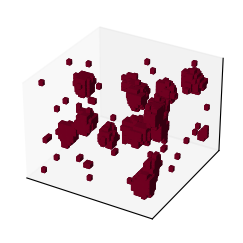

In [375]:
fmriu.plot3DImage(Zeta[len(Zeta)-1].reshape(dimx,dimy,dimz),0)

In [324]:
sum(sum(sum(im)))

1581.0

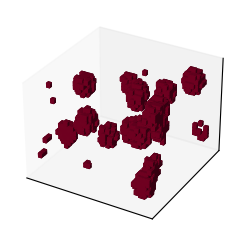

In [326]:
fmriu.plot3DImage(im,0)